In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score


In [85]:
# Load the dataset
dataset=pd.read_csv('/content/drive/MyDrive/Machine learning /automobile_failure_detection.csv')
dataset

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0


In [86]:
# Drop unnecessary columns
dataset = dataset.drop(['UDI', 'Product ID'], axis=1)

In [87]:
dataset.dtypes

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
dtype: object

In [88]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


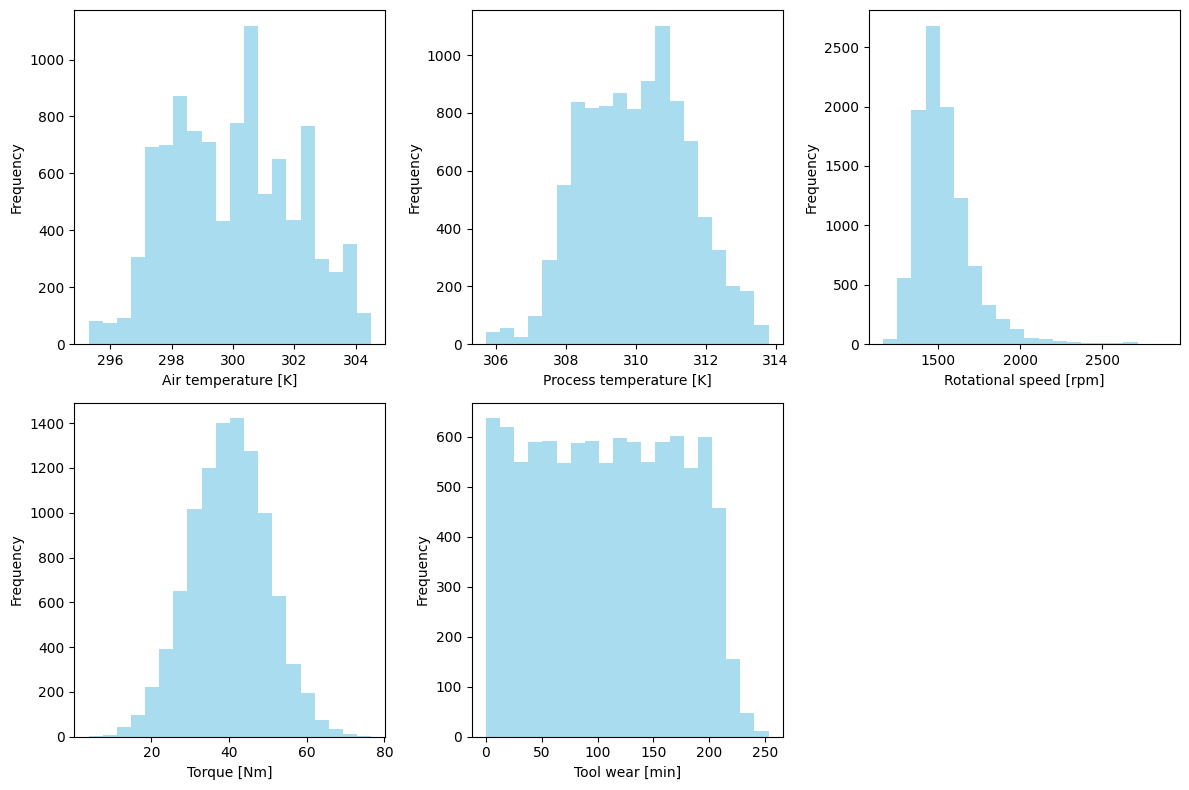

In [89]:
# Histograms for numerical features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'], start=1):
    plt.subplot(2, 3, i)
    plt.hist(dataset[feature], bins=20, color='skyblue', alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


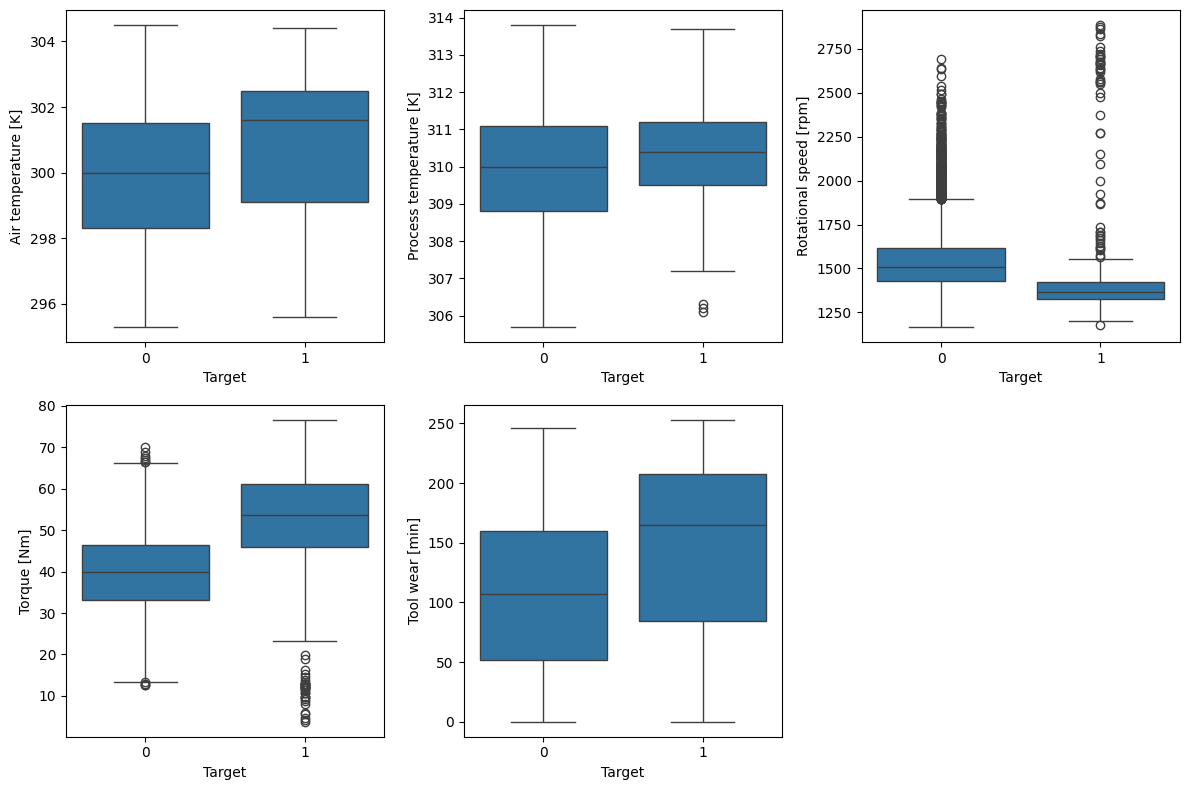

In [90]:
# Boxplots for numerical features by target variable
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'], start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Target', y=feature, data=dataset)
    plt.xlabel('Target')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


In [91]:

# Define the numerical features (excluding the target variable)
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Function to handle outliers using IQR method
def handle_outliers(data, features):
    for feature in features:
        # Calculate the IQR
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define the boundaries for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with NaN
        data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature] = np.nan

    return data

# Handle outliers
dataset_cleaned = handle_outliers(dataset.copy(), numerical_features)

# Drop rows with NaN values (outliers)
dataset_cleaned.dropna(inplace=True)

# Print the cleaned dataset
dataset_cleaned.head()


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551.0,42.8,0.0,0
1,L,298.2,308.7,1408.0,46.3,3.0,0
2,L,298.1,308.5,1498.0,49.4,5.0,0
3,L,298.2,308.6,1433.0,39.5,7.0,0
4,L,298.2,308.7,1408.0,40.0,9.0,0


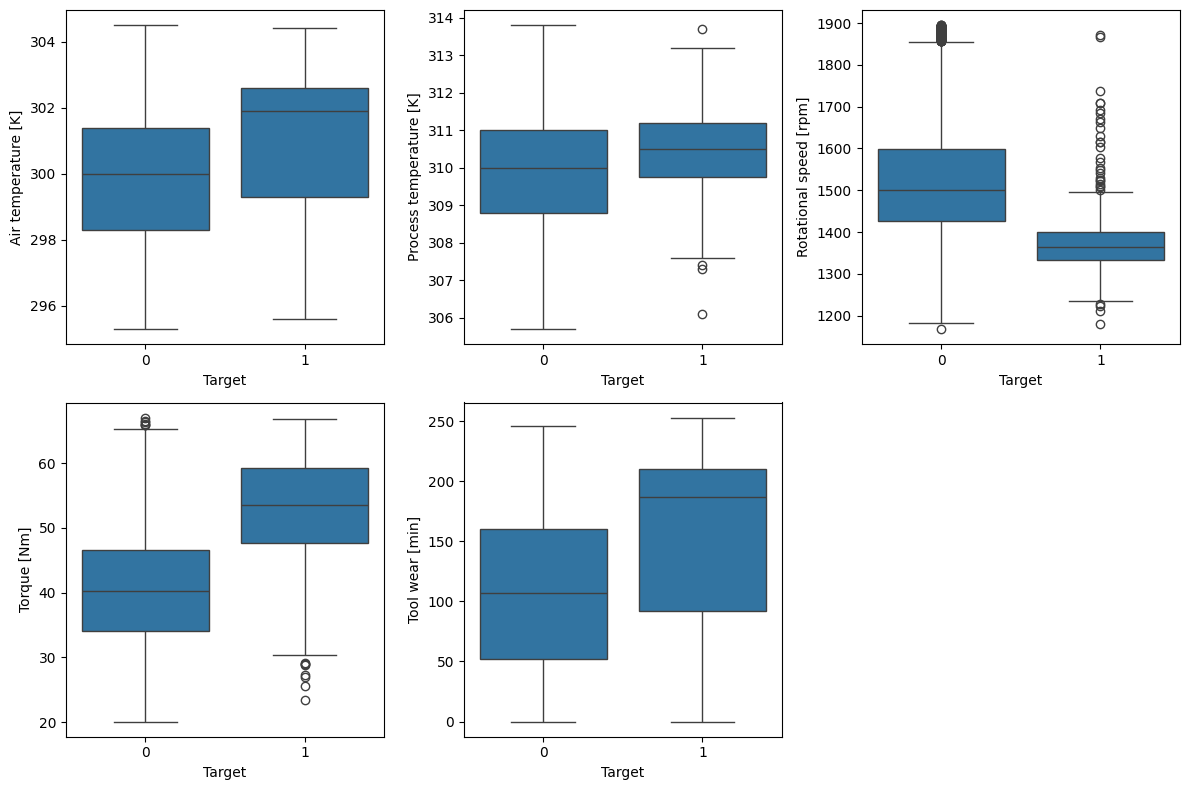

In [92]:
#After outliers are handled
# Boxplots for numerical features by target variable
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'], start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Target', y=feature, data=dataset_cleaned)
    plt.xlabel('Target')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [93]:
# Convert categorical variables to numerical using label encoding
label_encoder = LabelEncoder()
for column in dataset.select_dtypes(include=['object']):
    dataset[column] = label_encoder.fit_transform(dataset[column])

In [94]:
# Split dataset into features (X) and target variable (y)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [95]:
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [96]:
X_balanced.describe().T

,count,mean,std,min,25%,50%,75%,max
Type,19322.0,1.084722,0.533748,0.0,1.000000,1.0,1.000000,2.0
Air temperature [K],19322.0,300.456252,1.951130,295.3,298.865906,300.6,302.200000,304.5
Process temperature [K],19322.0,310.154999,1.326443,305.7,309.200000,310.3,311.046847,313.8
Rotational speed [rpm],19322.0,1516.027533,292.983390,1168.0,1357.000000,1426.0,1563.000000,2886.0
Torque [Nm],19322.0,44.918805,14.058851,3.8,35.995375,46.6,54.833800,76.6
Tool wear [min],19322.0,124.979195,69.737204,0.0,65.000000,127.0,193.000000,253.0


In [97]:
X_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19322 entries, 0 to 19321
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     19322 non-null  int64  
 1   Air temperature [K]      19322 non-null  float64
 2   Process temperature [K]  19322 non-null  float64
 3   Rotational speed [rpm]   19322 non-null  int64  
 4   Torque [Nm]              19322 non-null  float64
 5   Tool wear [min]          19322 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 905.8 KB


In [98]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [99]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13525 entries, 10588 to 15795
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     13525 non-null  int64  
 1   Air temperature [K]      13525 non-null  float64
 2   Process temperature [K]  13525 non-null  float64
 3   Rotational speed [rpm]   13525 non-null  int64  
 4   Torque [Nm]              13525 non-null  float64
 5   Tool wear [min]          13525 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 739.6 KB


In [101]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5797 entries, 5426 to 1521
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     5797 non-null   int64  
 1   Air temperature [K]      5797 non-null   float64
 2   Process temperature [K]  5797 non-null   float64
 3   Rotational speed [rpm]   5797 non-null   int64  
 4   Torque [Nm]              5797 non-null   float64
 5   Tool wear [min]          5797 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 317.0 KB


In [102]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'K Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

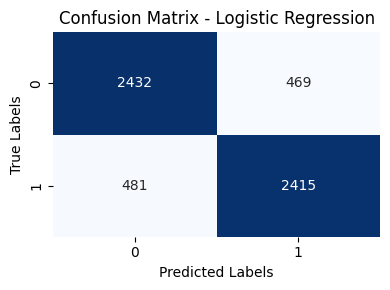

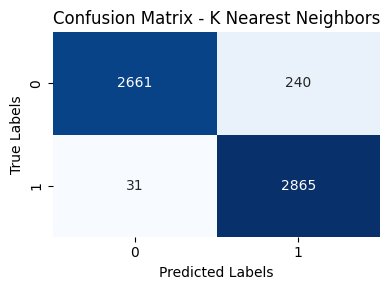

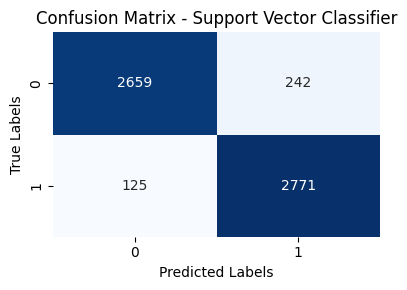

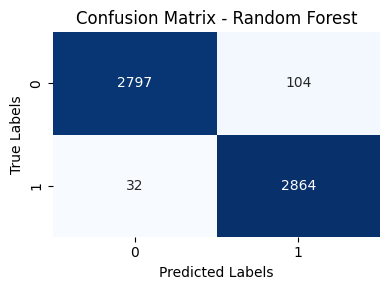

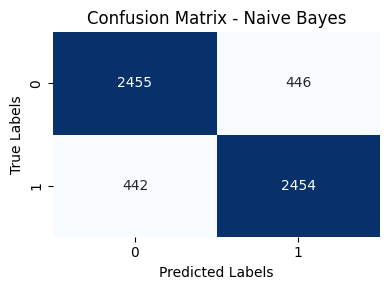

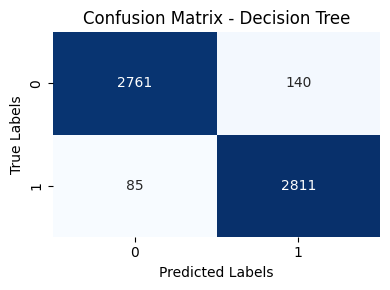

In [103]:
# Create an empty list to store accuracy data
accuracy_data = []

# Create an empty dictionary to store confusion matrices
conf_matrices = {}

# Train and evaluate each model
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store accuracy data
    accuracy_data.append({'Model': name, 'Accuracy': accuracy})

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    conf_matrices[name] = conf_matrix

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))  # Adjust the size here
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()  # Improve spacing between subplots
    plt.show()


In [104]:
# Print accuracy data
print("Accuracy Data:")
accuracy_table=pd.DataFrame(accuracy_data)
accuracy_table

Accuracy Data:


,Model,Accuracy
0,Logistic Regression,0.836122
1,K Nearest Neighbors,0.953252
2,Support Vector Classifier,0.936691
3,Random Forest,0.976540
4,Naive Bayes,0.846817
5,Decision Tree,0.961187


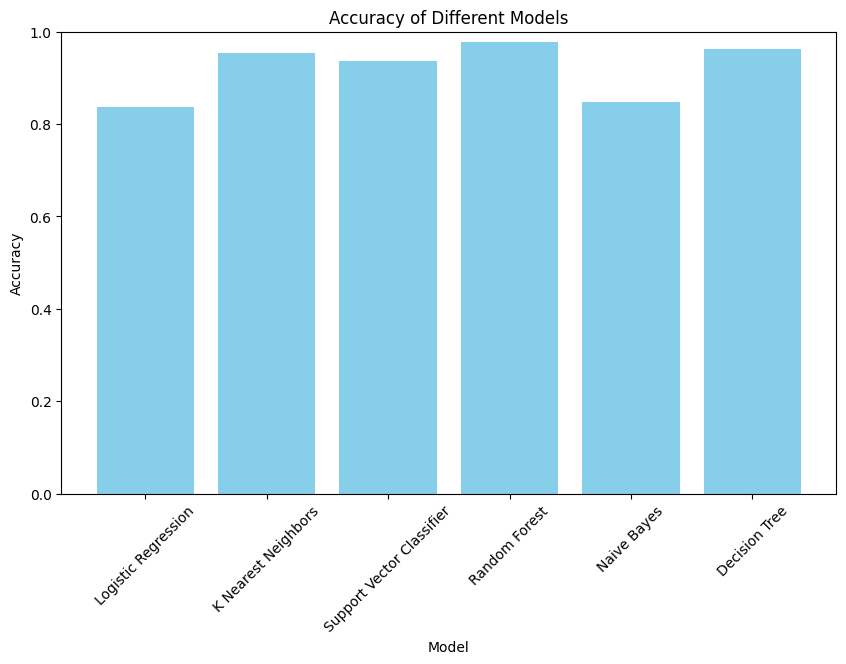

In [105]:
# Plot accuracy chart
plt.figure(figsize=(10, 6))
plt.bar(accuracy_table['Model'], accuracy_table['Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()
